In [1]:
!pip3 install -q torchsummary
from sklearn.model_selection import train_test_split
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from torch.utils.data import Dataset
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import torch

import os
from tqdm.notebook import tqdm
#from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary
from torchvision import transforms




[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!nvidia-smi

Thu Feb 29 09:24:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:01:00.0 Off |                  N/A |
| 41%   25C    P8               9W / 280W |   6950MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else 'cpu')


In [4]:
import os
import pandas as pd

def gather_image_data(base_dir):
    """
    Walk through the directory structure starting from base_dir to collect
    image paths, main class, and sub-class labels.
    
    Args:
    - base_dir (str): Path to the base directory of the dataset.
    
    Returns:
    - A tuple of lists: (image_paths, main_classes, sub_classes)
    """
    image_paths = []
    main_classes = []
    sub_classes = []
    
    # Walk through the directory structure
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):  # Check for image files
                # Construct the full path to the image file
                path = os.path.join(root, file)
                image_paths.append(path)
                
                # Extract main class and sub-class from the path
                parts = path.split(os.sep)  # os.sep for OS compatibility
                main_class = parts[-3]  # Adjust based on your directory structure
                sub_class = parts[-2]
                
                main_classes.append(main_class)
                sub_classes.append(sub_class)
    
    return image_paths, main_classes, sub_classes

def save_to_csv(image_paths, main_classes, sub_classes, csv_file):
    """
    Save the collected data into a CSV file.
    
    Args:
    - image_paths (list): List of image paths.
    - main_classes (list): List of main class labels.
    - sub_classes (list): List of sub-class labels.
    - csv_file (str): Filename for the output CSV.
    """
    # Create a DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'main_class': main_classes,
        'sub_class': sub_classes
    })
    
    # Save the DataFrame to a CSV file
    df.to_csv(csv_file, index=False)
    print(f'Data saved to {csv_file}')

# Set the base directory where your dataset is stored
base_dir = 'dataset/'

# Gather image data
image_paths, main_classes, sub_classes = gather_image_data(base_dir)

# Specify the CSV file name
csv_file = 'image_data.csv'

# Save data to CSV
save_to_csv(image_paths, main_classes, sub_classes, csv_file)

Data saved to image_data.csv


In [5]:
## create split 
df = pd.read_csv('image_data.csv')
# Assuming 'df' is your DataFrame loaded from 'image_data.csv'
main_class_le = LabelEncoder()
sub_class_le = LabelEncoder()

df['main_class_encoded'] = main_class_le.fit_transform(df['main_class'])
df['sub_class_encoded'] = main_class_le.fit_transform(df['sub_class'])

# Fit label encoders and transform classes to integer labels
df['main_class_encoded'] = main_class_le.fit_transform(df['main_class'])
df['sub_class_encoded'] = sub_class_le.fit_transform(df['sub_class'])


# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)  # 20% for validation

# Optionally, save the split datasets to new CSV files (optional but useful for large datasets)
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)

train_df.head()

,image_path,main_class,sub_class,main_class_encoded,sub_class_encoded
2187,dataset/Breast_Cancer/Yes/yes (489).png,Breast_Cancer,Yes,0,2
1569,dataset/Lung_Cancer/Yes/000147.png,Lung_Cancer,Yes,1,2
2515,dataset/Breast_Cancer/Yes/yes (782).png,Breast_Cancer,Yes,0,2
1025,dataset/Skin_cancer/No/56gfd4.jpg,Skin_cancer,No,2,1
2402,dataset/Breast_Cancer/Yes/yes (811).png,Breast_Cancer,Yes,0,2


In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.image_labels = pd.read_csv(annotations_file)
        # Initialize and fit the label encoder for main classes
        self.main_class_le = LabelEncoder()
        
        # If sub_class needs encoding, initialize and fit another LabelEncoder similarly
        
        self.transform = transform

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_labels.iloc[idx, 0]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        main_class = self.image_labels.iloc[idx, 1]
        sub_class = self.image_labels.iloc[idx, 2]  # Assuming sub_class is already an integer
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, main_class, sub_class

In [7]:
# Training transformations with more augmentations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.2),
    #A.GaussianBlur(p=0.2),
    A.Resize(256, 256),
    A.Normalize(mean=(0), std=(1)),
    ToTensorV2(),
])

# Validation transformations with minimal augmentations
val_transforms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0), std=(1)),
    ToTensorV2(),
])

# Create dataset instances
train_dataset = CustomImageDataset(annotations_file='train_data.csv', transform=train_transforms)
val_dataset = CustomImageDataset(annotations_file='val_data.csv', transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)

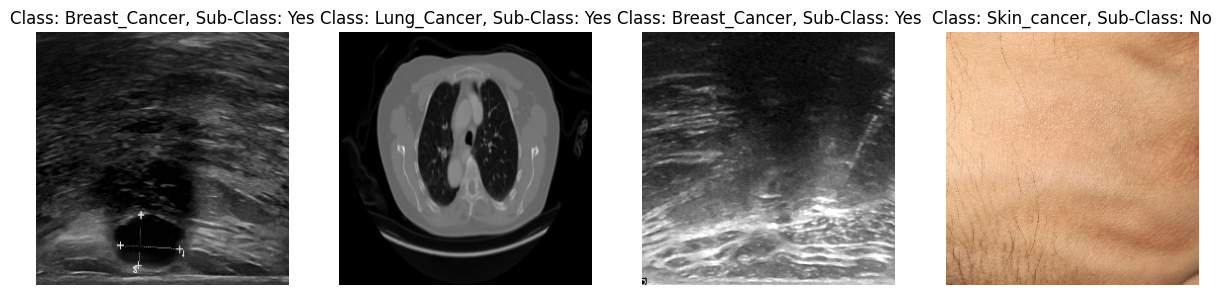

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(dataset, main_class_le, sub_class_le):
    """Plot images with class and subclass labels.
    
    Args:
    - dataset: A list of tuples, where each tuple contains (image, main_class, sub_class).
    - main_class_le: The LabelEncoder instance for main classes.
    - sub_class_le: The LabelEncoder instance for sub classes.
    """
    fig, axs = plt.subplots(1, len(dataset), figsize=(15, 5))
    for i, (image, main_class, sub_class) in enumerate(dataset):
        # Assuming image is a PyTorch tensor, normalize and convert for display
        img_display = image.permute(1, 2, 0).numpy()
        img_display = (img_display)  # Apply reverse normalization if needed
        img_display = np.clip(img_display, 0, 1)
        
        # Reverse label encoding to get original labels
        main_class_label = main_class_le.inverse_transform([main_class])[0]
        sub_class_label = sub_class_le.inverse_transform([sub_class])[0]
        
        axs[i].imshow(img_display)
        axs[i].set_title(f"Class: {main_class_label}, Sub-Class: {sub_class_label}")
        axs[i].axis('off')
    plt.show()

# Example usage
# Ensure you have a small dataset or a subset for demonstration
subset_dataset = [(train_dataset[i][0], train_dataset[i][1], train_dataset[i][2]) for i in range(4)]  # Adjust as necessary
plot_images(subset_dataset, main_class_le, sub_class_le)

## Model Definition

In [9]:
'''Convolutional Block Attention Module (CBAM)
'''

import torch
import torch.nn as nn
from torch.nn.modules import pooling
from torch.nn.modules.flatten import Flatten



class Channel_Attention(nn.Module):
    '''Channel Attention in CBAM.
    '''

    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        '''Param init and architecture building.
        '''

        super(Channel_Attention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=channel_in, out_features=channel_in//reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=channel_in//reduction_ratio, out_features=channel_in)
        )


    def forward(self, x):
        '''Forward Propagation.
        '''

        channel_attentions = []

        for pool_types in self.pool_types:
            if pool_types == 'avg':
                pool_init = nn.AvgPool2d(kernel_size=(x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                avg_pool = pool_init(x)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_types == 'max':
                pool_init = nn.MaxPool2d(kernel_size=(x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                max_pool = pool_init(x)
                channel_attentions.append(self.shared_mlp(max_pool))

        pooling_sums = torch.stack(channel_attentions, dim=0).sum(dim=0)
        scaled = nn.Sigmoid()(pooling_sums).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * scaled #return the element-wise multiplication between the input and the result.


class ChannelPool(nn.Module):
    '''Merge all the channels in a feature map into two separate channels where the first channel is produced by taking the max values from all channels, while the
       second one is produced by taking the mean from every channel.
    '''
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)


class Spatial_Attention(nn.Module):
    '''Spatial Attention in CBAM.
    '''

    def __init__(self, kernel_size=7):
        '''Spatial Attention Architecture.
        '''

        super(Spatial_Attention, self).__init__()

        self.compress = ChannelPool()
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=kernel_size, stride=1, dilation=1, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(num_features=1, eps=1e-5, momentum=0.01, affine=True)
        )


    def forward(self, x):
        '''Forward Propagation.
        '''
        x_compress = self.compress(x)
        x_output = self.spatial_attention(x_compress)
        scaled = nn.Sigmoid()(x_output)
        return x * scaled


class CBAM(nn.Module):
    '''CBAM architecture.
    '''
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        '''Param init and arch build.
        '''
        super(CBAM, self).__init__()
        self.spatial = spatial

        self.channel_attention = Channel_Attention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)

        if self.spatial:
            self.spatial_attention = Spatial_Attention(kernel_size=7)


    def forward(self, x):
        '''Forward Propagation.
        '''
        x_out = self.channel_attention(x)
        if self.spatial:
            x_out = self.spatial_attention(x_out)

        return x_out

'''Deep Hierarchical Classifier using resnet50 with cbam as the base.
'''

import torch
import torch.nn as nn

class BottleNeck(nn.Module):
    '''Bottleneck modules
    '''

    def __init__(self, in_channels, out_channels, expansion=4, stride=1, use_cbam=True):
        '''Param init.
        '''
        super(BottleNeck, self).__init__()

        self.use_cbam = use_cbam
        #only the first conv will be affected by the given stride parameter. The rest have default stride value (which is 1).
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False, stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=out_channels*expansion)
        self.relu = nn.ReLU(inplace=True)

        #since the input has to be same size with the output during the identity mapping, whenever the stride or the number of output channels are
        #more than 1 and expansion*out_channels respectively, the input, x, has to be downsampled to the same level as well.
        self.identity_connection = nn.Sequential()
        if stride != 1 or in_channels != expansion*out_channels:
            self.identity_connection = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=expansion*out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels*expansion)
            )

        if self.use_cbam:
            self.cbam = CBAM(channel_in=out_channels*expansion)


    def forward(self, x):
        '''Forward Propagation.
        '''

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.use_cbam:
            out = self.cbam(out)

        out += self.identity_connection(x) #identity connection/skip connection
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    '''ResNet-50 Architecture.
    '''

    def __init__(self, use_cbam=True, image_depth=3, num_classes=[20,100]):
        '''Params init and build arch.
        '''
        super(ResNet50, self).__init__()

        self.in_channels = 64
        self.expansion = 4
        self.num_blocks = [3, 4, 6, 3]

        self.conv_block1 = nn.Sequential(nn.Conv2d(kernel_size=3, stride=1, in_channels=image_depth, out_channels=self.in_channels, padding=1, bias=False),
                                            nn.BatchNorm2d(self.in_channels),
                                            nn.ReLU(inplace=True))

        self.layer1 = self.make_layer(out_channels=64, num_blocks=self.num_blocks[0], stride=1, use_cbam=use_cbam)
        self.layer2 = self.make_layer(out_channels=128, num_blocks=self.num_blocks[1], stride=2, use_cbam=use_cbam)
        self.layer3 = self.make_layer(out_channels=256, num_blocks=self.num_blocks[2], stride=1, use_cbam=use_cbam)
        self.layer4 = self.make_layer(out_channels=512, num_blocks=self.num_blocks[3], stride=2, use_cbam=use_cbam)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear_lvl1 = nn.Linear(512*self.expansion, num_classes[0])
        self.linear_lvl2 = nn.Linear(512*self.expansion, num_classes[1])

        self.softmax_reg1 = nn.Linear(num_classes[0], num_classes[0])
        self.softmax_reg2 = nn.Linear(num_classes[0]+num_classes[1], num_classes[1])



    def make_layer(self, out_channels, num_blocks, stride, use_cbam):
        '''To construct the bottleneck layers.
        '''
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BottleNeck(in_channels=self.in_channels, out_channels=out_channels, stride=stride, expansion=self.expansion, use_cbam=use_cbam))
            self.in_channels = out_channels * self.expansion
        return nn.Sequential(*layers)


    def forward(self, x):
        '''Forward propagation of ResNet-50.
        '''

        x = self.conv_block1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x_conv = self.layer4(x)
        x = self.avgpool(x_conv)
        x = nn.Flatten()(x) #flatten the feature maps.

        level_1 = self.softmax_reg1(self.linear_lvl1(x))
        level_2 = self.softmax_reg2(torch.cat((level_1, self.linear_lvl2(x)), dim=1))



        return level_1, level_2

## Loss Hieracial Loss

In [10]:
import torch
import torch.nn as nn

class HierarchicalLossNetwork:
    '''Logics to calculate the loss of the model, assuming main classes and sub classes are predefined integers.
    '''

    def __init__(self, hierarchical_labels, device='cpu', total_level=2, alpha=1, beta=0.8, p_loss=3):
        '''Param init.
        '''
        self.total_level = total_level
        self.alpha = alpha
        self.beta = beta
        self.p_loss = p_loss
        self.device = device
        self.hierarchical_labels = hierarchical_labels
        # No need for conversion, assuming hierarchical_labels are already in the correct integer format
        self.numeric_hierarchy = hierarchical_labels

    def check_hierarchy(self, current_level, previous_level):
        '''Check if the predicted class at level l is a child of the class predicted at level l-1 for the entire batch.
        '''
        bool_tensor = [not current_level[i] in self.numeric_hierarchy.get(previous_level[i].item(), []) for i in range(previous_level.size()[0])]
        return torch.FloatTensor(bool_tensor).to(self.device)

    def calculate_lloss(self, predictions, true_labels):
        '''Calculates the layer loss.
        '''
        lloss = 0
        for l in range(self.total_level):
            lloss += nn.CrossEntropyLoss()(predictions[l], true_labels[l])
        return self.alpha * lloss

    def calculate_dloss(self, predictions, true_labels):
        '''Calculate the dependence loss.
        '''
        dloss = 0
        for l in range(1, self.total_level):
            current_lvl_pred = torch.argmax(nn.Softmax(dim=1)(predictions[l]), dim=1)
            prev_lvl_pred = torch.argmax(nn.Softmax(dim=1)(predictions[l-1]), dim=1)

            D_l = self.check_hierarchy(current_lvl_pred, prev_lvl_pred)

            l_prev = torch.where(prev_lvl_pred == true_labels[l-1], torch.FloatTensor([0]).to(self.device), torch.FloatTensor([1]).to(self.device))
            l_curr = torch.where(current_lvl_pred == true_labels[l], torch.FloatTensor([0]).to(self.device), torch.FloatTensor([1]).to(self.device))

            dloss += torch.sum(torch.pow(self.p_loss, D_l*l_prev)*torch.pow(self.p_loss, D_l*l_curr) - 1)

        return self.beta * dloss


In [11]:



def calculate_accuracy(predictions, labels):
    '''Calculates the accuracy of the prediction.
    '''

    num_data = labels.size(0)  # Number of data points
    predicted = torch.argmax(predictions, dim=1)  # Get the index of max log-probability

    correct_pred = torch.sum(predicted == labels).float()  # Convert to float to ensure float division

    accuracy = (correct_pred / num_data) * 100  # Calculate accuracy as a percentage

    return accuracy.item()  # Convert to Python number

def calculate_accuracy(predictions, labels):
    '''Calculates the accuracy of the prediction.
    '''

    num_data = labels.size()[0]
    predicted = torch.argmax(predictions, dim=1)

    correct_pred = torch.sum(predicted == labels)

    accuracy = correct_pred*(100/num_data)

    return accuracy.item()


In [15]:
hierarchy = {
    0: [0, 1],  # Main class 0 has sub-classes 0 and 1
    1: [0, 1],  # Main class 1 has sub-classes 0 and 1
    2: [0, 1],  # Main class 2 has sub-classes 0 and 1
    3: [0, 1]   # Main class 3 has sub-classes 0 and 1
}

epoch = 5
model_save_path = 'baseline/'


HLN = HierarchicalLossNetwork(hierarchical_labels=hierarchy, device=device)
model = ResNet50()
optimizer = Adam(model.parameters(), lr=1e-4)

model = model.to(device)


train_epoch_loss = []
train_epoch_superclass_accuracy = []
train_epoch_subclass_accuracy = []

test_epoch_loss = []
test_epoch_superclass_accuracy = []
test_epoch_subclass_accuracy = []
train_true_labels = []
train_pred_labels = []
test_true_labels = []
test_pred_labels = []

for epoch_idx in range(epoch):

    i = 0

    epoch_loss = []
    epoch_superclass_accuracy = []
    epoch_subclass_accuracy = []

    model.train()
    for i, (image, label_1, label_2) in tqdm(enumerate(train_loader), total=len(train_loader)):



        batch_x, batch_y1, batch_y2 = image.to(device), label_1.to(device), label_2.to(device)
        optimizer.zero_grad()

        superclass_pred,subclass_pred = model(batch_x)
        prediction = [superclass_pred, subclass_pred]
        dloss = HLN.calculate_dloss(prediction, [batch_y1, batch_y2])
        lloss = HLN.calculate_lloss(prediction, [batch_y1, batch_y2])

        total_loss = lloss + dloss
        total_loss.backward()
        optimizer.step()
        epoch_loss.append(total_loss.item())
        epoch_superclass_accuracy.append(calculate_accuracy(predictions=prediction[0].detach(), labels=batch_y1))
        epoch_subclass_accuracy.append(calculate_accuracy(predictions=prediction[1].detach(), labels=batch_y2))
        # For training
        train_true_labels.extend(batch_y1.cpu().numpy())  # Assuming you're predicting superclass here
        train_pred_labels.extend(torch.argmax(prediction[0], dim=1).cpu().numpy())  

    train_epoch_loss.append(sum(epoch_loss)/(i+1))
    train_epoch_superclass_accuracy.append(sum(epoch_superclass_accuracy)/(i+1))
    train_epoch_subclass_accuracy.append(sum(epoch_subclass_accuracy)/(i+1))
    


    print(f'Training Loss at epoch {epoch_idx} : {sum(epoch_loss)/(i+1)}')
    print(f'Training Superclass accuracy at epoch {epoch_idx} : {sum(epoch_superclass_accuracy)/(i+1)}')
    print(f'Training Subclass accuracy at epoch {epoch_idx} : {sum(epoch_subclass_accuracy)/(i+1)}')
   

    j = 0

    epoch_loss = []
    epoch_superclass_accuracy = []
    epoch_subclass_accuracy = []

    model.eval()
    with torch.set_grad_enabled(False):
        for j, (image, label_1, label_2) in tqdm(enumerate(val_loader), total=len(val_loader)):



            batch_x, batch_y1, batch_y2 = image.to(device), label_1.to(device), label_2.to(device)

            superclass_pred,subclass_pred = model(batch_x)
            prediction = [superclass_pred,subclass_pred]
            dloss = HLN.calculate_dloss(prediction, [batch_y1, batch_y2])
            lloss = HLN.calculate_lloss(prediction, [batch_y1, batch_y2])

            total_loss = lloss + dloss

            epoch_loss.append(total_loss.item())
            epoch_superclass_accuracy.append(calculate_accuracy(predictions=prediction[0].detach(), labels=batch_y1))
            epoch_subclass_accuracy.append(calculate_accuracy(predictions=prediction[1].detach(), labels=batch_y2))
            # For confusion matrix
            test_true_labels.extend(batch_y1.cpu().numpy())
            test_pred_labels.extend(torch.argmax(prediction[0], dim=1).cpu().numpy())


    test_epoch_loss.append(sum(epoch_loss)/(j+1))
    test_epoch_superclass_accuracy.append(sum(epoch_superclass_accuracy)/(j+1))
    test_epoch_subclass_accuracy.append(sum(epoch_subclass_accuracy)/(j+1))
    

    #plot accuracy and loss graph
   

    print(f'Testing Loss at epoch {epoch_idx} : {sum(epoch_loss)/(j+1)}')
    print(f'Testing Superclass accuracy at epoch {epoch_idx} : {sum(epoch_superclass_accuracy)/(j+1)}')
    print(f'Testing Subclass accuracy at epoch {epoch_idx} : {sum(epoch_subclass_accuracy)/(j+1)}')
    print('-------------------------------------------------------------------------------------------')

    torch.save(model.state_dict(), model_save_path.rstrip('/')+'dhc.pth')
    print("Model saved!")

  0%|          | 0/563 [00:00<?, ?it/s]

Training Loss at epoch 0 : 3.0098428154499874
Training Superclass accuracy at epoch 0 : 87.34458259325045
Training Subclass accuracy at epoch 0 : 82.99289520426288


  0%|          | 0/282 [00:00<?, ?it/s]

Testing Loss at epoch 0 : 1.1608510537861554
Testing Superclass accuracy at epoch 0 : 92.90780141843972
Testing Subclass accuracy at epoch 0 : 88.82978723404256
-------------------------------------------------------------------------------------------
Model saved!


  0%|          | 0/563 [00:00<?, ?it/s]

Training Loss at epoch 1 : 1.494544731482837
Training Superclass accuracy at epoch 1 : 96.49200710479573
Training Subclass accuracy at epoch 1 : 86.14564831261102


  0%|          | 0/282 [00:00<?, ?it/s]

Testing Loss at epoch 1 : 0.6082329213490638
Testing Superclass accuracy at epoch 1 : 99.29078014184397
Testing Subclass accuracy at epoch 1 : 87.76595744680851
-------------------------------------------------------------------------------------------
Model saved!


  0%|          | 0/563 [00:00<?, ?it/s]

Training Loss at epoch 2 : 1.1572936644205298
Training Superclass accuracy at epoch 2 : 98.00177619893428
Training Subclass accuracy at epoch 2 : 87.47779751332149


  0%|          | 0/282 [00:00<?, ?it/s]

Testing Loss at epoch 2 : 0.6798578747138438
Testing Superclass accuracy at epoch 2 : 98.22695035460993
Testing Subclass accuracy at epoch 2 : 89.36170212765957
-------------------------------------------------------------------------------------------
Model saved!


  0%|          | 0/563 [00:00<?, ?it/s]

Training Loss at epoch 3 : 0.9883188708498413
Training Superclass accuracy at epoch 3 : 98.57904085257549
Training Subclass accuracy at epoch 3 : 88.41030195381883


  0%|          | 0/282 [00:00<?, ?it/s]

Testing Loss at epoch 3 : 0.5067828547017333
Testing Superclass accuracy at epoch 3 : 99.11347517730496
Testing Subclass accuracy at epoch 3 : 90.60283687943263
-------------------------------------------------------------------------------------------
Model saved!


  0%|          | 0/563 [00:00<?, ?it/s]

Training Loss at epoch 4 : 0.8720817028658157
Training Superclass accuracy at epoch 4 : 99.1563055062167
Training Subclass accuracy at epoch 4 : 88.18827708703375


  0%|          | 0/282 [00:00<?, ?it/s]

Testing Loss at epoch 4 : 0.45355345943827285
Testing Superclass accuracy at epoch 4 : 98.75886524822695
Testing Subclass accuracy at epoch 4 : 89.18439716312056
-------------------------------------------------------------------------------------------
Model saved!


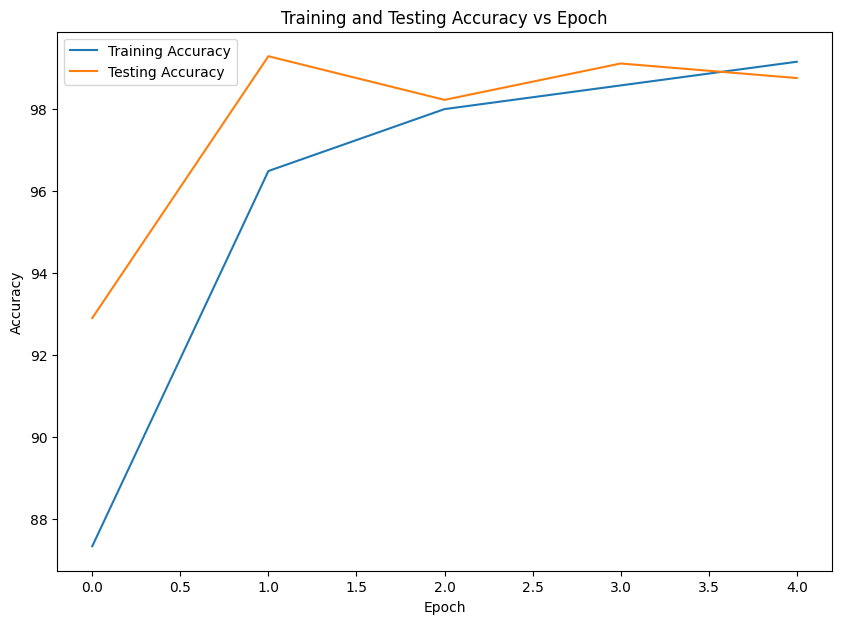

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(range(epoch), train_epoch_superclass_accuracy, label='Training Accuracy')
plt.plot(range(epoch), test_epoch_superclass_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs Epoch')
plt.legend()
plt.show()

